In [ ]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# load datasets.
data = pd.read_csv("/content/SMSSpamCollection", sep='\t', header=None)

alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm','n', 'o','p', 'q', 'r', 's', 't', 'u',
 'v', 'w', 'x','y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '/', '?', '!', '.', 'α', 'β', 'γ']

total_num_sms = len(data[0])

# preprocess the data
def data_preprocessing(sms):
    # convert to lowercase.
    sms = sms.lower()

    # replace all unknow character to 'γ', where 'γ' is
    # taken as replacement for unknown character.
    sms = "".join([ c if c in alphabet else 'γ' for c in sms ])

    # append start ('αα') and end ('ββ') symbols.
    sms = 'α' + 'α' + sms + 'β' + 'β'

    return sms

for i in range(total_num_sms):
    data[1][i] = data_preprocessing(data[1][i])

# determine min and max indices of train data.
train_min_index = 0
train_max_index = int((total_num_sms * 60) / 100)

# determine min and max indices of test data.
test_min_index = train_max_index + 1
test_max_index = total_num_sms

# determine number of classes.
num_classes = len(np.unique(data[0]))

bigram_count_spam = dict()
bigram_count_ham = dict()

# count character bigram in ham and spam training dataset.
def count_trainingset_bigram_spam_ham():
    # first set bigram count to 0.
    for first_char in alphabet:
        for second_char in alphabet:
            bigram = first_char + second_char
            bigram_count_spam[bigram] = 0
            bigram_count_ham[bigram] = 0

    # count each bigram in training data.
    for i in range(train_min_index, train_max_index):
        sms = data[1][i]
        if data[0][i] == "spam":
            for char in range(len(sms) - 1):
                bigram = sms[char] + sms[char + 1]
                bigram_count_spam[bigram] = bigram_count_spam[bigram] + 1
        else:
            for char in range(len(sms) - 1):
                bigram = sms[char] + sms[char + 1]
                bigram_count_ham[bigram] = bigram_count_ham[bigram] + 1

count_trainingset_bigram_spam_ham()

trigram_count_spam = dict()
trigram_count_ham = dict()

# count character trigram in ham and spam training dataset.
def count_trainingset_trigram_spam_ham():
   # first set trigram count to 0.
    for first_char in alphabet:
        for second_char in alphabet:
            for third_char in alphabet:
                trigram = first_char + second_char + third_char
                trigram_count_spam[trigram] = 0
                trigram_count_ham[trigram] = 0

     # count each trigram in training data.
    for i in range(train_min_index, train_max_index):
        sms = data[1][i]
        if data[0][i] == "spam":
            for char in range(len(sms) - 2):
                trigram = sms[char] + sms[char + 1] + sms[char + 2]
                trigram_count_spam[trigram] = trigram_count_spam[trigram] + 1
        else:
            for char in range(len(sms) - 2):
                trigram = sms[char] + sms[char + 1] + sms[char + 2]
                trigram_count_ham[trigram] = trigram_count_ham[trigram] + 1

count_trainingset_trigram_spam_ham()

# taking k as 0.5 for finding prediction.
k = 0.5

prob_trigram_ham = dict()
prob_trigram_spam = dict()

# determine probabilities of trigrams in training dataset.
def prob_trigram_spam_ham():
    for trigram, count in trigram_count_spam.items():
        trigram_first_two_char = trigram[0] + trigram[1]
        prob_trigram_spam[trigram] = (count + k) / (bigram_count_spam[trigram_first_two_char] + (k * len(alphabet)))

    for trigram, count in trigram_count_ham.items():
        trigram_first_two_char = trigram[0] + trigram[1]
        prob_trigram_ham[trigram] = (count + k) / (bigram_count_ham[trigram_first_two_char] + (k * len(alphabet)))

prob_trigram_spam_ham()

# determine log probability of a test SMS message.
# used log to eliminate arithmatic undeflow.
def log_probability(x, spam_ham):
    log_prob = 0
    if spam_ham == "spam":
        for char in range(len(x) - 2):
            trigram = x[char] + x[char + 1] + x[char + 2]
            log_prob = log_prob + math.log(prob_trigram_spam[trigram])
    else:
        for char in range(len(x) - 2):
            trigram = x[char] + x[char + 1] + x[char + 2]
            log_prob = log_prob + math.log(prob_trigram_ham[trigram])

    return log_prob

# predict the test SMS message for ham or spam.
def predict(x):
    spam_predict = log_probability(x, "spam")
    ham_predict = log_probability(x, "ham")
    
    if spam_predict >= ham_predict:
        return "spam"
    else:
        return "ham"

# predict test SMS message in each row in the test dataset
test_data_count = test_max_index - test_min_index
predicted_classes = np.empty((test_data_count), dtype="<U10")
for n in range(test_min_index, test_max_index):
    index = n - test_min_index
    predicted_classes[index] = predict(data[1][n])

print("predicted classes of test SMS messages")
print(predicted_classes)

actual_classes = np.array(data[0])[test_min_index:test_max_index]
print("actual classes of test SMS messages")
print(actual_classes)





predicted classes of test SMS messages
['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']
actual classes of test SMS messages
['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']


In [ ]:
confusion_matrix = confusion_matrix(predicted_classes, actual_classes)
print(confusion_matrix)
con_matrix= confusion_matrix



[[1916   18]
 [  11  283]]


In [ ]:
def diagonal_sum(con_matrix):
  sum = 0
  for i in range(2):
    for j in range(2):
      if i==j: sum+= con_matrix[i,j]
  return sum
dim = diagonal_sum(con_matrix)
print(f'Accuracy: {dim/2228}')

Accuracy: 0.9869838420107719


Text(69.0, 0.5, 'Predicted value')

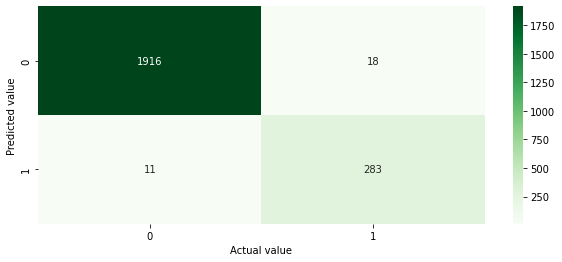

In [ ]:
plt.figure(figsize=(10,4))
ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Actual value')
plt.ylabel('Predicted value')

In [ ]:
from sklearn.metrics import classification_report
#predictions = nb_model.predict(x_test)
print(classification_report(predicted_classes, actual_classes,digits = 6))

              precision    recall  f1-score   support

         ham   0.994292  0.990693  0.992489      1934
        spam   0.940199  0.962585  0.951261       294

    accuracy                       0.986984      2228
   macro avg   0.967245  0.976639  0.971875      2228
weighted avg   0.987154  0.986984  0.987049      2228

